In [1]:
import warnings
warnings.filterwarnings("ignore")

# K-Nearest Neighbors with cuML
In this Notebook we will walk through what the K-Nearest Neighbors algorithm is, and how to implement it with RAPIDS cuML for both classification and regression.

Step 1: Start with a Dataset with Known Target Values
In our case, we have 3 species of Iris flower (Iris setosa, Iris virginica and Iris versicolor) from Fischer's Iris dataset.

In [2]:
import cudf

df = cudf.read_csv('https://github.com/gumdropsteve/datasets/raw/master/iris.csv')

In [41]:
df

,t_Year,t_Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted
0,1991.0,8.0,6.0,2.0,655.0,735.0,5.0,430.0,49.0,185.0,244.0,110.0,0.0
1,1990.0,11.0,19.0,1.0,1654.0,1847.0,4.0,262.0,117.0,156.0,11.0,595.0,0.0
2,1991.0,1.0,20.0,7.0,1700.0,1751.0,12.0,683.0,116.0,189.0,175.0,412.0,0.0
3,1991.0,6.0,25.0,2.0,2130.0,2303.0,3.0,618.0,96.0,180.0,11.0,545.0,0.0
4,1988.0,10.0,1.0,6.0,1611.0,1920.0,3.0,1630.0,126.0,226.0,171.0,866.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,1987.0,10.0,5.0,1.0,740.0,747.0,7.0,821.0,71.0,11.0,150.0,332.0,0.0
3999996,1990.0,7.0,28.0,6.0,955.0,1055.0,14.0,103.0,54.0,167.0,22.0,321.0,0.0
3999997,1987.0,11.0,28.0,6.0,1715.0,1741.0,3.0,1098.0,32.0,133.0,8.0,108.0,0.0
3999998,1991.0,8.0,26.0,1.0,1215.0,1335.0,14.0,103.0,66.0,27.0,149.0,395.0,0.0


In [4]:
df.species.unique()

0        setosa
1    versicolor
2     virginica
Name: species, dtype: object

#### Data Prep
Before we get too far ahead of ourselves, we should split our data into training and testing datasets. This allows us to test our model with actual data that the model has never seen.

In [45]:
from cuml.preprocessing.model_selection import train_test_split

df = df.drop('species')

X_train, X_test, y_train, y_test = train_test_split(df, 'target', train_size=0.8)

Often you will need to cluster that data (our data has already been clustered because we know the species of each recorded flower). This can be done a number of ways including [PCA](https://github.com/gumdropsteve/cuml_pca) and [K-Means](https://github.com/gumdropsteve/cuml_kmeans) clustering.

Let's convert our cudf.DataFrame `.to_pandas()` to easily visualize a our clusters with Matplotlib.

<AxesSubplot:xlabel='sepal_length', ylabel='petal_width'>

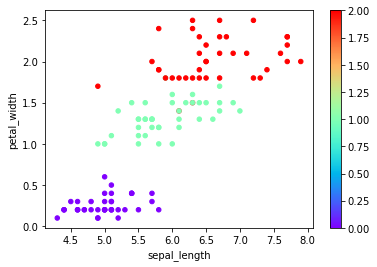

In [6]:
X_train.to_pandas().plot(kind='scatter', x='sepal_length', y='petal_width',
                         c=y_train.to_array(), cmap=('rainbow'), sharex=False)

#### Step 2: Add New Data with Unknown Target Values
It's time to add in our testing data. Let's scatter the `X_test` flowers in black on top  of the rainbow plot to better understand where they're coming from.

In [7]:
from matplotlib import pyplot as plt

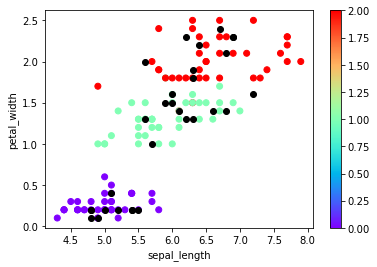

In [8]:
plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# scatter training dataset (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# scatter testing dataset (black)
plt.scatter(x=X_test['sepal_length'].to_pandas(), y=X_test['petal_width'].to_pandas(),
            color='k')

While it's pretty easy to guess which test flowers are setosa, it's not so obvious for the virginica or the versicolor.

## K-Nearest Neighbors Classification vs Regression

### **Classifier**

K-Nearest Neighbors Classifier is an instance-based learning technique,
that keeps training samples around for prediction, rather than trying
to learn a generalizable set of model parameters.

In [9]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
results = knn.predict(X_test)

results.tail()

#### Classifier Results
Making a `.copy()` of the `X_test` DataFrame, we can add `actual` and `predicted` columns from `y_test` and `results` values (respectively).

This results DataFrame (`df`) will help us examine performance.

In [12]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,6.2,3.4,5.4,2.3,2,2
146,5.4,3.7,1.5,0.2,0,0
147,5.5,3.5,1.3,0.2,0,0
148,4.8,3.1,1.6,0.2,0,0
149,6.3,2.7,4.9,1.8,2,2


How many instances did we `.predict()` correctly?

In [13]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible * 100)[:5]}% accuracy')

28 / 30 correct
93.33% accuracy


Visualize by adding the correctly predicted species to the rainbow map alongside `X_train` and the incorrectly predicted flowers in black.

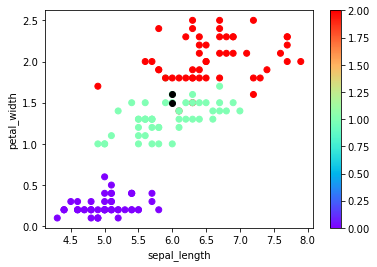

In [14]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black) (except: means 1 or less incorrect)
try:
    plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')
except:
    plt.scatter(x=df_incorrect['sepal_length'], y=df_incorrect['petal_width'], color='k')

And let's see those rows.

In [15]:
df_incorrect

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
140,6.0,2.2,5.0,1.5,2,1
141,6.0,2.7,5.1,1.6,1,2


### **Regressor**
K-Nearest Neighbors Regressor is an instance-based learning technique that keeps training samples around for prediction, rather than trying to learn a generalizable set of model parameters. The K-Nearest Neighbors Regressor will compute the average of the labels for the k closest neighbors and use it as the label.

Creating the model, fitting it with data, and making predictions is done the same here for regression as it just was for classification.

In [16]:
from cuml.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)

In [17]:
knn.fit(X_train, y_train)

KNeighborsRegressor(weights='uniform')

In [18]:
results = knn.predict(X_test)

results.tail()

25    2.000000
26    0.000000
27    0.000000
28    0.000000
29    1.666667
dtype: float32

Because of the nature of regression, results are returned as floating point values. Notice some predictions might have neighbors of different species, leading the `KNeighborsRegressor` to predict values like 1.666667.

#### Regressor Results
Let's add back the actual (`y_test`) values along with the predicted (`results`) to a `.copy()` of the `X_test` DataFrame and show the last 5 rows.

In [19]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,6.2,3.4,5.4,2.3,2,2.000000
146,5.4,3.7,1.5,0.2,0,0.000000
147,5.5,3.5,1.3,0.2,0,0.000000
148,4.8,3.1,1.6,0.2,0,0.000000
149,6.3,2.7,4.9,1.8,2,1.666667


How many instances did we `.predict()` correctly?

In [20]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible * 100)[:5]}% accuracy')

26 / 30 correct
86.66% accuracy


Visualize by adding the correctly predicted species to the rainbow map alongside `X_train` and the incorrectly predicted flowers in black.

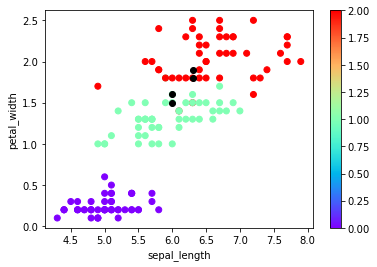

In [21]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black) (except: means 1 or less incorrect)
try:
    plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')
except:
    plt.scatter(x=df_incorrect['sepal_length'], y=df_incorrect['petal_width'], color='k')

In [22]:
df_incorrect

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
133,6.3,2.5,5.0,1.9,2,1.666667
140,6.0,2.2,5.0,1.5,2,1.333333
141,6.0,2.7,5.1,1.6,1,2.000000
149,6.3,2.7,4.9,1.8,2,1.666667


## Nearest Neighbors
Before we wrap up K-Nearest Neighbors, we should get familiar with the Nearest Neighbors algorithm, which enables the query of the K-Nearest Neighbors from a set of input samples. cuML uses [Faiss](https://github.com/facebookresearch/faiss) to run the Nearest Neighbors query.

In [23]:
from cuml.neighbors import NearestNeighbors

nn = NearestNeighbors()

Let's `.fit()` the `NearestNeighbors` model with our `X_train` data. Note the model is being fed all 4 measurements from each flower, but it is not being told which species any of those flowers belong to.

In [37]:
nn.fit(X_train)

NearestNeighbors(n_neighbors=5, verbose=2, handle=<cuml.common.handle.Handle object at 0x7fe0ec0b20b0>, algorithm='brute', metric='euclidean', output_type='cudf')

We can now call `.kneighbors()` to query for the k nearest neighbors of column vectors in `df`. The method returns a tuple with 2 cudf.DataFrames holding the *distances* and *indices* of the k-nearest neighbors for each column vector in X.

Let's query for the 3 nearest neighbors of the first 5 points in our testing set (`X_test`).

In [33]:
distances, indices = nn.kneighbors(X_test[:5], n_neighbors=3)

How far away are the 3 nearest points?

In [34]:
distances

,0,1,2
0,0.244944,0.346425,0.360551
1,0.000000,0.000000,0.173202
2,0.199983,0.331652,0.346392
3,0.223614,0.282839,0.299994
4,0.173202,0.173213,0.223605


At what indices (of `X_train`) can those points be found?

In [35]:
indices

,0,1,2
0,1,93,74
1,10,30,71
2,44,17,77
3,63,58,18
4,70,22,13


# Continued Learning 
Here are some resources to help fill in any gaps and provide a more complete picture.

#### **StatQuest: K-nearest neighbors, Clearly Explained**
- Watch on YouTube: [youtu.be/HVXime0nQeI](https://youtu.be/HVXime0nQeI)
- Channel: StatQuest with Josh Starmer ([Subscribe](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw?sub_confirmation=1))

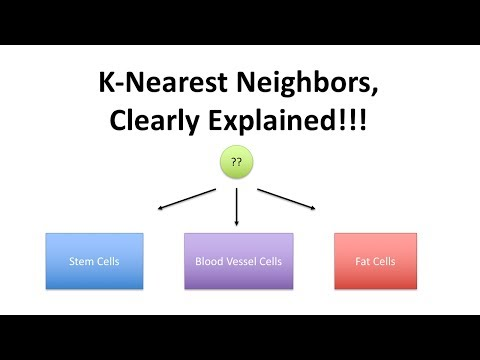

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo('HVXime0nQeI', width=(1280*0.69), height=(720*0.69))

#### **_k_-nearest neighbors algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

#### **Nearest Neighbour Algorithm - Part 1**
- Watch on YouTube: [youtu.be/JH2IUFmP8JI](https://youtu.be/JH2IUFmP8JI)
- Channel:  Darren Barton ([Subscribe](https://www.youtube.com/user/bartondeb1?sub_confirmation=1))

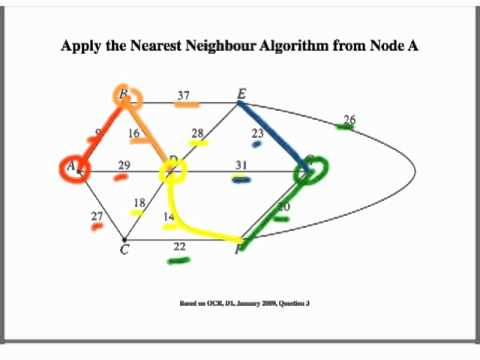

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('JH2IUFmP8JI', width=720, height=480)

#### **Nearest neighbour algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) 